In [1]:
# Variational AutoEncoder - Fashion dataset
#
# import the necessary packages
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
from keras import backend as K
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pandas as pd
import numpy as np

In [2]:
# load the fashion dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
#x_test = x_test.astype('float32')
#x_train = x_train / 255.
#x_test = x_test / 255.

x_train = np.array(x_train).reshape(-1, 28, 28) / 255.0
x_test = np.array(x_test).reshape(-1, 28, 28) / 255.0

4431872/4422102 [==============================] - 0s 0us/step


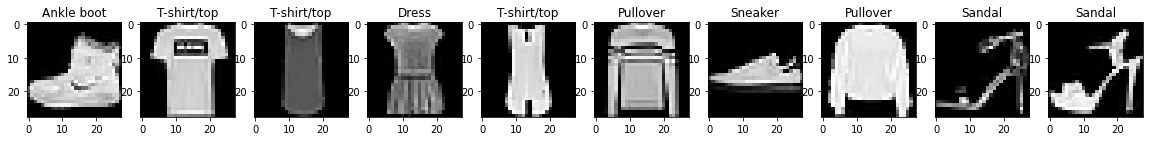

In [3]:
# Show images
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [4]:
# Notice.
# Using only two latent variable
# Compare to description on p.84, chapter 3.
# About: mean and log_variance vectors,
# These two vectors are also known as latent-variables.
# The output of the model will be passed to the sampling network. 
# The Network ( encoder ) learns to map the data ( Fashion-MNIST ) to two latent variables 
#( mean & variance vectors ) that are expected to follow a normal distribution

def make_and_fit():
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2, activation='relu')(x)

    encoder = Model(inputs=inputs, outputs=encoded)

    encoded_inputs = Input(shape=(2,))

    x = Dense(4, activation='relu')(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)

    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=  tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    print(model.summary())
    
    clr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)
    
    model.fit(
        x_train,
        x_train,
        batch_size=256,
        epochs=25,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[clr])

    return model, encoder, decoder

model, encoder, decoder = make_and_fit()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 34889     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         42417     
                                                                 
Total params: 77,306
Trainable params: 77,082
Non-trainable params: 224
_________________________________________________________________
None
Epoch 1/25
235/235 [==============================] - 30s 75ms/step - loss: 0.4066 - accuracy: 0.4896 - mse: 0.0565 - val_loss: 1.7514 - val_accuracy: 0.4999 - val_mse: 0.2051 - lr: 0.0010
Epoch 2/25
235/235 [==============================] - 17s 71ms/step - loss: 0.3631 - accuracy: 0.4946 - mse: 0.0416 - val_l

In [5]:
# return input, latent representation and output
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs

# show input, latent representation and output
def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 5))
    for i in range(n):
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
show_encodings(*get_triple(x_test[:10]))
inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

[2132 2465 9269 9931 5453 2086 9598 3365 2166 8386]
10 random inputs: 


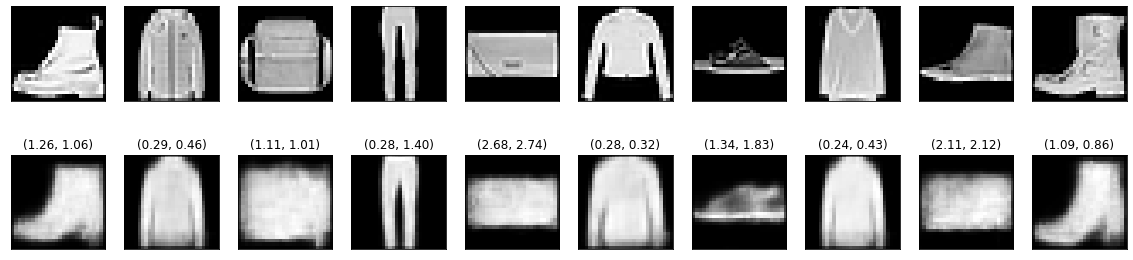

In [102]:
idx = np.random.choice(len(x_test), 10)
print(idx)
inputs = x_test[idx]
print('10 random inputs: ')
show_encodings(*get_triple(inputs))

10
latent points: 
p1=[[0.27795798]
 [1.4047798 ]], 
p2=[[1.0915253]
 [0.8594848]]


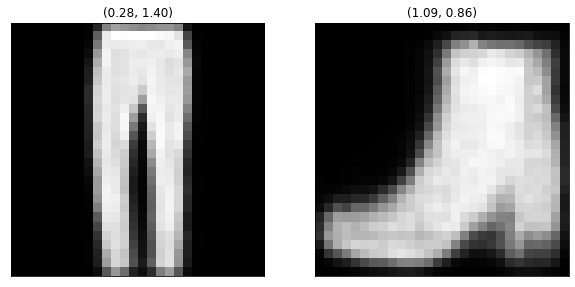

In [104]:
# get latent coordinates and outputs of the 2 desired items
inputs_points, latent_r, outputs_points = get_triple(inputs)
print(len(inputs))
p1, output1 = latent_r[3], outputs_points[3] # first coordinate and output
p2, output2 = latent_r[9], outputs_points[9] # second coordinate and output
print(f'latent points: \np1={p1}, \np2={p2}')
fix, axes = plt.subplots(1, 2, figsize=(2*5, 5))

axes[0].set_title('({0:.2f}, {1:.2f})'.format(float(p1[0]), float(p1[1])))
axes[0].imshow(output1.reshape(28, 28), cmap='gray')
axes[1].set_title('({0:.2f}, {1:.2f})'.format(float(p2[0]), float(p2[1])))
axes[1].imshow(output2.reshape(28, 28), cmap='gray')
for ax in axes.flatten():
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [105]:
# array for size 10 for traversing 2d latent space
x = np.random.normal(size = (10,2))
journey_x = np.linspace(p1[0], p2[0], 10)
journey_y = np.linspace(p1[1], p2[1], 10)
print(journey_x, journey_y)
for i in range(0,10,1):
  x[i, 0] = journey_x[i]
  x[i, 1] = journey_y[i]
print(x)
lp_outputs = decoder.predict(x)
x = x.reshape((x.shape[0], x.shape[1], 1))

[[0.27795798]
 [0.36835435]
 [0.45875072]
 [0.5491471 ]
 [0.6395435 ]
 [0.7299398 ]
 [0.8203362 ]
 [0.91073257]
 [1.0011289 ]
 [1.0915253 ]] [[1.4047798 ]
 [1.3441914 ]
 [1.2836031 ]
 [1.2230148 ]
 [1.1624265 ]
 [1.1018381 ]
 [1.0412498 ]
 [0.98066145]
 [0.92007315]
 [0.8594848 ]]
[[0.27795798 1.40477979]
 [0.36835435 1.34419143]
 [0.45875072 1.28360307]
 [0.54914713 1.22301483]
 [0.63954347 1.16242647]
 [0.72993982 1.10183811]
 [0.82033622 1.04124975]
 [0.91073257 0.98066145]
 [1.00112891 0.92007315]
 [1.09152532 0.85948479]]


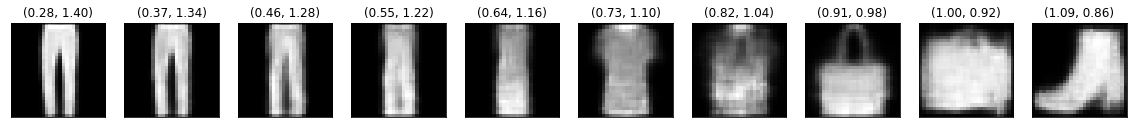

In [107]:
fix, axes = plt.subplots(1, 10, figsize=(2*10, 5))
for i in range(len(x)):
  axes[i].set_title('({0:.2f}, {1:.2f})'.format(float(x[i, 0]), float(x[i, 1])))
  axes[i].imshow(lp_outputs[i].reshape(28, 28), cmap='gray')
for ax in axes.flatten():
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [108]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

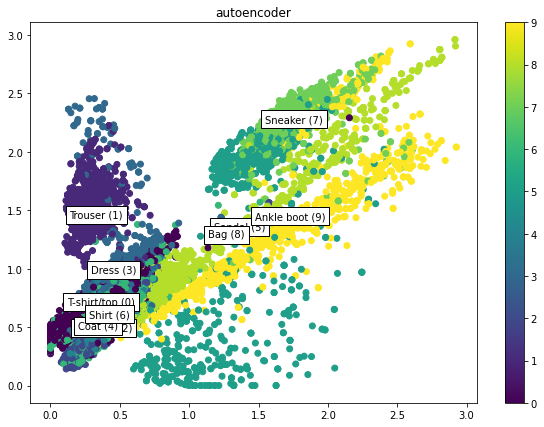

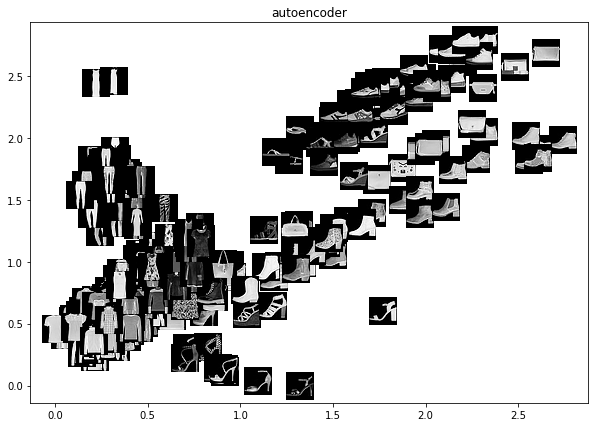

In [109]:
plot_latent('dots', 10000, 'autoencoder')

plot_latent('imgs', 300, 'autoencoder')